![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers_v2.5.ipynb)

# Clinical Entity Resolvers (v 2.5)

## Colab Setup

In [1]:
import json

with open('workshop_license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

dict_keys(['secret', 'SPARK_NLP_LICENSE', 'JSL_OCR_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'JSL_OCR_SECRET'])

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

secret = license_keys['secret']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['JSL_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']

! python -m pip install --upgrade spark-nlp-jsl==2.5.0rc1  --extra-index-url https://pypi.johnsnowlabs.com/$secret

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.5

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl



def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.0") \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-2.5.0rc4.jar")
      
    return builder.getOrCreate()


spark = start(secret) # if you want to start the session with custom params as in start function above
# sparknlp_jsl.start(secret)

In [ ]:
sparknlp_jsl.version()

'2.5.0rc1'

In [ ]:
spark

# Clinical Resolvers

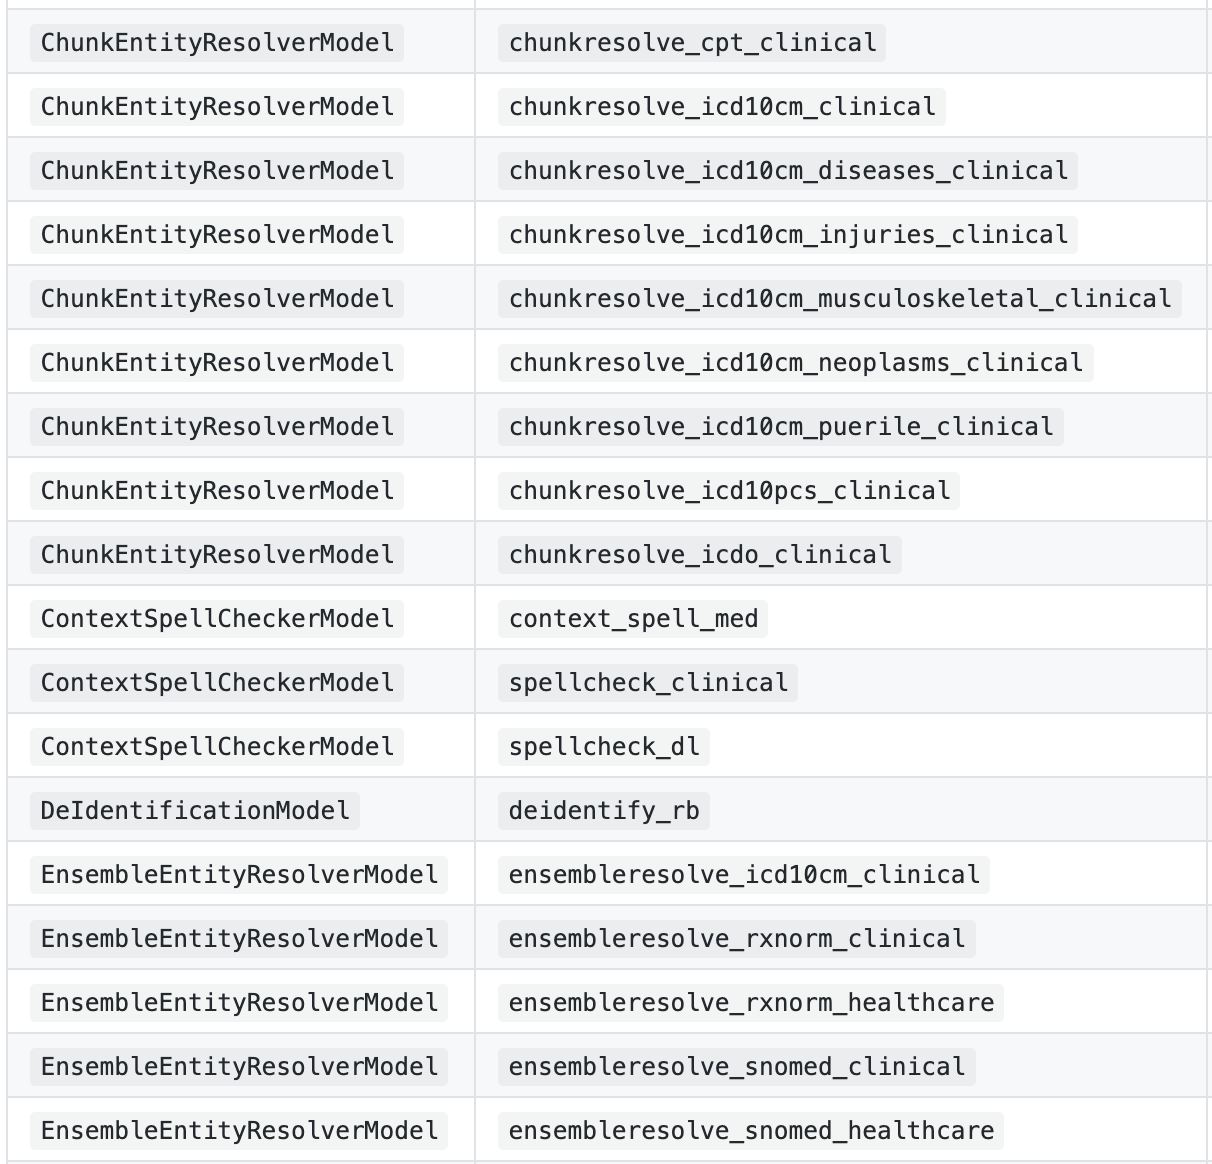

## Entity Resolvers for ICD-10

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- alternative_confidence_ratios -> Rest of confidence ratios
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId
- chunk -> ChunkId

In [ ]:
import sys, os, time
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.util import *
from sparknlp_jsl.annotator import *

from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

### Clinical NER Pipeline creation

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

The fourth annotator in the pipeline is "WordEmbeddingsModel". We will download a pretrained model available from "clinical/models" named "embeddings_clinical".

When running this cell your are advised to be patient.

First time you call this pretrained model it needs to be downloaded in your local.

The model size is about will download the embeddings_clinical corpus it takes a while.

The size is about 1.7Gb and will be saved typically in your home folder as

~HOMEFOLDER/cached_models/embeddings_clinical_en_2.0.2_2.4_1558454742956.zip

Next times you call it the model is loaded from your cached copy but even in that case it needs to be indexed each time so expect waiting up to 5 minutes (depending on your machine)

In [5]:
# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


The fifth and final annotator in our NER pipeline is the pretrained `ner_clinical` NerDLModel avaliable from "clinical/models". It requires as input the "sentence", "token" and "embeddings" (clinical embeddings pretrained model) and will classify each token in four categories:

- PROBLEM: for patient problems

- TEST: for tests, labs, etc.

- TREATMENT: for treatments, medicines, etc.

- OTHER: for the rest of tokens.

In order to split those identified NER that are consecutive, the B prefix (as B-PROBLEM) will be used at the first token of each NER. The I prefix (as I-PROBLEM) will be used for the rest of tokens inside the NER.

In [6]:
# Named Entity Recognition for clinical concepts.

clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


### Define the NER pipeline

Now we will define the actual pipeline that puts together the annotators we have created.

In [ ]:
# Build up the pipeline

pipeline_ner = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner
  ])

### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [ ]:

clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [ ]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [ ]:
model = pipeline_ner.fit(data_ner)

### Transform / annotate the clinical note using the model.

In order to process the data with the new created model we have two options.

The first one would be to use the model to transform our clinical note by the command:

`output = model_ner.transform(data_ner)`

That would save in a Spakr DataFrame (output) the resuls of running the model over the clinical note.

However for small tests like this or for real-time request a LightPipelines is a simpler way of managing the data. It will return a dictionary (instead of a Spark DataFrame) with the results of the transformation

We will create a light_pipeline_ner using our model_ner and then will annotate the clinical_note using this light_pipeline.

In [ ]:
light_pipeline = LightPipeline(model)
light_data = light_pipeline.annotate(clinical_note)

Now we have a dictionaty (light_data_ner) that contains the results of running the NER pipeline over our clinical note.

It contains the original document:

In [ ]:
light_data['document'][0][0:100]


'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to '

In [ ]:
print("Number of sentences: {}".format(len(light_data['sentence'])))
print("")
for i in range(5):
    print("Sentence {}: {}".format(i, light_data['sentence'][i][0:80]))

Number of sentences: 17

Sentence 0: A 28-year-old female with a history of gestational diabetes mellitus diagnosed e
Sentence 1: Two weeks prior to presentation, she was treated with a five-day course of amoxi
Sentence 2: She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and
Sentence 3: She had been on dapagliflozin for six months at the time of presentation.
Sentence 4: Physical examination on presentation was significant for dry oral mucosa;


In [ ]:
print("Number of tokens: {}".format(len(light_data['token'])))
print("")
for i in range(25):
    print("Token {}: {} ({})".format(i, light_data['token'][i][0:20], light_data['ner'][i]))
print("...")

Number of tokens: 436

Token 0: A (O)
Token 1: 28-year-old (O)
Token 2: female (O)
Token 3: with (O)
Token 4: a (O)
Token 5: history (O)
Token 6: of (O)
Token 7: gestational (B-PROBLEM)
Token 8: diabetes (I-PROBLEM)
Token 9: mellitus (I-PROBLEM)
Token 10: diagnosed (O)
Token 11: eight (O)
Token 12: years (O)
Token 13: prior (O)
Token 14: to (O)
Token 15: presentation (O)
Token 16: and (O)
Token 17: subsequent (O)
Token 18: type (B-PROBLEM)
Token 19: two (I-PROBLEM)
Token 20: diabetes (I-PROBLEM)
Token 21: mellitus (I-PROBLEM)
Token 22: ( (O)
Token 23: T2DM (B-PROBLEM)
Token 24: ), (I-PROBLEM)
...


Lets apply some HTML formating to see the results of the pipeline in a nicer layout:



In [ ]:
import random
from IPython.core.display import display, HTML


def get_color():
    r = lambda: random.randint(100,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def get_NER_html (light_data):

    html_output=''
    
    problem_flag = False
    new_problem = []
    problem_list = []
    
    label_list = list(set([i.split('-')[1] for i in light_data['ner'] if i!='O']))
    
        
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color()
            
    for index, this_token in enumerate(light_data['token']):

        try:
            ent = light_data['ner'][index].split('-')[1]
        except:
            ent = light_data['ner'][index]
        
       
        if ent in label_list:
            color = label_color[ent]
            html_output+='<SPAN style="background-color: {}">'.format(color) + this_token + " </SPAN>"
        else:
            html_output+=this_token + " "
        

    html_output += '</div>'
    html_output += '<div>Color codes:'
    

    for l in label_list:
        
        html_output += '<SPAN style="background-color: {}">{}</SPAN>, '.format(label_color[l],l)
   
    
    return display(HTML(html_output))


In [ ]:
get_NER_html (light_data)

##  ICD10 coding Pipeline creation.

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the wordembeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- NerDLModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- ChunkTokenizer (ner_chunk -> ner_chunk_tokenized)

- ICD10CMEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

- ICD10PCSEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, ChunkEmbeddigns, EntityResolverModel for ICD10CM and EntityResolverModel for ICD10PCS.

Now we define the new pipeline




In [ ]:
# Named Entity Recognition concepts parser, transforms entities into CHUNKS (required for next step: assertion status)

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['PROBLEM'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

chunk_tokenizer = ChunkTokenizer()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_token")

# ICD resolution model

icd10cm_resolution = ChunkEntityResolverModel.pretrained("chunkresolve_icd10cm_clinical", "en", "clinical/models") \
  .setInputCols(["ner_token", "chunk_embeddings"]) \
  .setOutputCol("icd10cm_code") \
  .setDistanceFunction("COSINE")  \
  .setNeighbours(5)

chunkresolve_icd10cm_clinical download started this may take some time.
Approximate size to download 166.3 MB
[OK!]


In [ ]:

pipeline_icd10 = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    icd10cm_resolution
  ])

model_icd10 = pipeline_icd10.fit(data_ner)


In [ ]:
light_pipeline_icd10 = LightPipeline(model_icd10)


In [ ]:
text = light_data['document'][0]

text

'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 2

In [ ]:
import pandas as pd


light_result = light_pipeline_icd10.annotate(text)

df = pd.DataFrame(list(zip(light_result['ner_chunk'], light_result['icd10cm_code'])),
                  columns = ['Problem','ICD10-CM-Code'])

df

,Problem,ICD10-CM-Code
0,gestational diabetes mellitus,P702
1,type two diabetes mellitus,E1142
2,"T2DM),",E1121
3,HTG-induced pancreatitis,B252
4,an acute hepatitis,B172
5,obesity,E661
6,a body mass index,Z681
7,BMI) of 33.5 kg/m2,Z6831
8,polyuria,R358
9,polydipsia,R631


In [ ]:
def get_icd10_codes (light_model, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  resolved= []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0]['icd10cm_code']):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolved.append(code.metadata['resolved_text'])
      resolutions.append(code.metadata['all_k_resolutions'])
      
  import pandas as pd

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'icd10_cm_code':codes, 'resolved_text':resolved,
                    'target_text':resolutions})

  return df




In [ ]:
df = get_icd10_codes (light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolved_text,target_text
0,gestational diabetes mellitus,39,67,P702,Neonatal diabetes mellitus,Neonatal diabetes mellitus:::Type 2 diabetes m...
1,type two diabetes mellitus,128,153,E1142,Type 2 diabetes mellitus with diabetic polyneu...,Type 2 diabetes mellitus with diabetic polyneu...
2,"T2DM),",156,161,E1121,Type 2 diabetes mellitus with diabetic nephrop...,Type 2 diabetes mellitus with diabetic nephrop...
3,HTG-induced pancreatitis,184,207,B252,Cytomegaloviral pancreatitis,Cytomegaloviral pancreatitis:::Alcohol-induced...
4,an acute hepatitis,260,277,B172,Acute hepatitis E,Acute hepatitis E:::Autoimmune hepatitis:::Mum...
5,obesity,284,290,E661,Drug-induced obesity,Drug-induced obesity:::Other obesity:::Bariatr...
6,a body mass index,297,313,Z681,"Body mass index (BMI) 19.9 or less, adult","Body mass index (BMI) 19.9 or less, adult:::Bo..."
7,BMI) of 33.5 kg/m2,316,333,Z6831,"Body mass index (BMI) 31.0-31.9, adult","Body mass index (BMI) 31.0-31.9, adult:::Body ..."
8,polyuria,373,380,R358,Other polyuria,Other polyuria:::Polydipsia:::Generalized edem...
9,polydipsia,383,392,R631,Polydipsia,Polydipsia:::Anhedonia:::Galactorrhea


In [ ]:
output = model_icd10.transform(data_ner).cache()

output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata",
                                     "icd10cm_code.result","icd10cm_code.metadata")).alias("icd10cm_result")) \
.select(F.expr("icd10cm_result['0']").alias("chunk"),
        F.expr("icd10cm_result['1'].entity").alias("entity"),
        F.expr("icd10cm_result['3'].resolved_text").alias("resolved_text"),
        F.expr("icd10cm_result['2']").alias("code"),
        F.expr("icd10cm_result['3'].all_k_resolutions").alias("cms"))\
.distinct() \
.toPandas()


,chunk,entity,resolved_text,code,cms
0,starvation ketosis,PROBLEM,Propionic acidemia,E71121,Propionic acidemia:::Propionic acidemia:::Type...
1,Her euDKA,PROBLEM,"Abnormal finding of blood chemistry, unspecified",R799,"Abnormal finding of blood chemistry, unspecifi..."
2,HTG-induced pancreatitis,PROBLEM,Cytomegaloviral pancreatitis,B252,Cytomegaloviral pancreatitis:::Alcohol-induced...
3,significant lipemia,PROBLEM,Gestational [pregnancy-induced] hypertension w...,O134,Gestational [pregnancy-induced] hypertension w...
4,guarding,PROBLEM,Dysuria,R300,Dysuria:::Periumbilic rebound abdominal tender...
5,vomiting,PROBLEM,Bilious vomiting,R1114,Bilious vomiting:::Projectile vomiting:::Bilio...
6,polydipsia,PROBLEM,Polydipsia,R631,Polydipsia:::Polydipsia:::Glycosuria:::Other p...
7,a respiratory tract infection,PROBLEM,Acute nasopharyngitis [common cold],J00,Acute nasopharyngitis [common cold]:::Herpesvi...
8,her respiratory tract infection,PROBLEM,Acute nasopharyngitis [common cold],J00,Acute nasopharyngitis [common cold]:::Diseases...
9,HTG,PROBLEM,Pure hyperglyceridemia,E781,Pure hyperglyceridemia:::Pure hyperglyceridemi...


In [ ]:
text = 'He has a brain damage and lung cancer'

df = get_icd10_codes(light_pipeline_icd10, text)

df

,chunks,begin,end,icd10_cm_code,resolved_text,target_text
0,a brain damage,7,20,G9382,Brain death,Brain death:::Cerebral ischemia:::Cerebral edema
1,lung cancer,26,36,J676,Maple-bark-stripper's lung,Maple-bark-stripper's lung:::Mushroom-worker's...


# RxNorm Resolver

In [ ]:
data_ner.show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [ ]:
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['TREATMENT'])

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

chunk_tokenizer = ChunkTokenizer()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_token")

rxnormResolver = EnsembleEntityResolverModel()\
    .pretrained('ensembleresolve_rxnorm_small_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([1,3,2,0,0,1])\
    .setInputCols('ner_token', 'chunk_embeddings')\
    .setOutputCol('rxnorm_resolution')\


pipeline_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    rxnormResolver
  ])

model_rxnorm = pipeline_rx.fit(data_ner)


ensembleresolve_rxnorm_small_clinical download started this may take some time.
Approximate size to download 159.7 MB
[OK!]


In [ ]:
output = model_rxnorm.transform(data_ner)

output.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|    chunk_embeddings|           ner_token|   rxnorm_resolution|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|A 28-year-old fem...|[[document, 0, 24...|[[document, 0, 42...|[[token, 0, 0, A,...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 499, 509...|[[word_embeddings...|[[token, 499, 509...|[[entity, 499, 50...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [ ]:
output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias('confidence')).show(truncate = 100)

+--------------------+---------+----------------------------------------------------------------------------------------------------+-------+---------------------------+
|               chunk|   entity|                                                                                         target_text|   code|rxnorm_result.3[confidence]|
+--------------------+---------+----------------------------------------------------------------------------------------------------+-------+---------------------------+
|         amoxicillin|TREATMENT|ciprofloxacin kit:::ciprofloxacin kit:::amoxicillin 5 0 0 mg oral tablet:::amoxicillin 2 5 0 mg o...| 309310|                     0.5000|
|           metformin|TREATMENT|metformin hydrochloride tablets:::metformin hydrochloride oral solution:::pioglitazone tablets:::...|2054650|                     0.9931|
|           glipizide|TREATMENT|glipizide 5 mg oral tablet [ glucotrol ] :::glimepiride 3 mg oral tablet:::glimepiride 8 mg oral ...| 205828|         

In [ ]:
text = 'The patient was prescribed 1 capsule of Advil for 5 days after meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day.'
text

'The patient was prescribed 1 capsule of Advil for 5 days after meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day.'

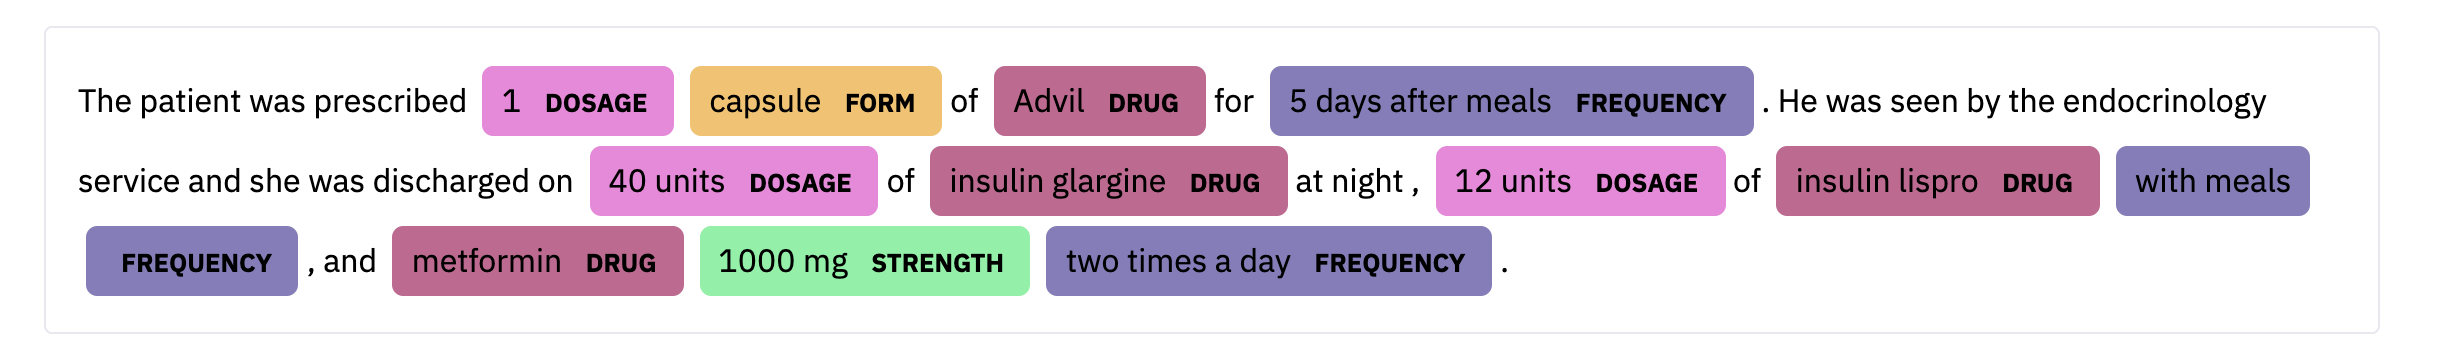

In [ ]:

data_ner = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
posology_ner = NerDLModel.pretrained("ner_posology", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")\
  .setWhiteList(['DRUG'])

posology_rx = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    rxnormResolver
  ])

model_rxnorm = posology_rx.fit(data_ner)

output = model_rxnorm.transform(data_ner)

output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata","rxnorm_resolution.result","rxnorm_resolution.metadata")).alias("rxnorm_result")) \
    .select(F.expr("rxnorm_result['0']").alias("chunk"),
            F.expr("rxnorm_result['1'].entity").alias("entity"),
            F.expr("rxnorm_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("rxnorm_result['2']").alias("code"),
            F.expr("rxnorm_result['3'].confidence").alias("confidence")).show(truncate = 100)

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
+----------------+------+----------------------------------------------------------------------------------------------------+-------+---------------------------+
|           chunk|entity|                                                                                         target_text|   code|rxnorm_result.3[confidence]|
+----------------+------+----------------------------------------------------------------------------------------------------+-------+---------------------------+
|           Advil|  DRUG|moxetumomab pasudotox - tdfk 1 mg injection [ lumoxiti ] :::phenolphthalein 9 0 mg oral tablet [ ...|2099314|                     1.0000|
|insulin glargine|  DRUG|insulin glargine 1 0 0 units / ml subcutaneous solution:::insulin glargine 3 0 0 units / ml subcu...| 311041|                     0.4944|
|  insulin lispro|  DRUG|insulin lispro 1 0 0 units / ml subcutaneous solution:::insuli

In [ ]:
model_rxnorm.stages

In [ ]:
model_rxnorm.save('posology_rxNorm_resolver')

In [ ]:
from pyspark.ml import PipelineModel

loaded_rxnorm = PipelineModel.load('posology_rxNorm_resolver')

loaded_rxnorm.stages

[DocumentAssembler_a9085590892e,
 SentenceDetector_d34fe428e87c,
 REGEX_TOKENIZER_6de8ac361d85,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 NerDLModel_d6171a6a5d57,
 NerConverter_32d459c5db5e,
 ChunkEmbeddings_2628b1f1e0e4,
 CHUNK_TOKENIZER_7d4cf18dc190,
 ENSER_MODEL_ef77f462b393]

In [ ]:
loaded_rxnorm.transform(data_ner).select("ner_chunk.result","rxnorm_resolution.result").show(truncate=100)

+----------------------------------------------------+----------------------------------+
|                                              result|                            result|
+----------------------------------------------------+----------------------------------+
|[Advil, insulin glargine, insulin lispro, metformin]|[2099314, 311041, 242120, 2054650]|
+----------------------------------------------------+----------------------------------+



# ICD10 + RxNorm with multiple NERs

In [ ]:
notes = [
'Pentamidine 300 mg IV q . 36 hours , Pentamidine nasal wash 60 mg per 6 ml of sterile water q.d . , voriconazole 200 mg p.o . b.i.d . , acyclovir 400 mg p.o . b.i.d . , cyclosporine 50 mg p.o . b.i.d . , prednisone 60 mg p.o . q.d . , GCSF 480 mcg IV q.d . , Epogen 40,000 units subcu q . week , Protonix 40 mg q.d . , Simethicone 80 mg p.o . q . 8 , nitroglycerin paste 1 " ; q . 4 h . p.r.n . , flunisolide nasal inhaler , 2 puffs q . 8 , OxyCodone 10-15 mg p.o . q . 6 p.r.n . , Sudafed 30 mg q . 6 p.o . p.r.n . , Fluconazole 2% cream b.i.d . to erythematous skin lesions , Ditropan 5 mg p.o . b.i.d . , Tylenol 650 mg p.o . q . 4 h . p.r.n . , Ambien 5-10 mg p.o . q . h.s . p.r.n . , Neurontin 100 mg q . a.m . , 200 mg q . p.m . , Aquaphor cream b.i.d . p.r.n . , Lotrimin 1% cream b.i.d . to feet , Dulcolax 5-10 mg p.o . q.d . p.r.n . , Phoslo 667 mg p.o . t.i.d . , Peridex 0.12% , 15 ml p.o . b.i.d . mouthwash , Benadryl 25-50 mg q . 4-6 h . p.r.n . pruritus , Sarna cream q.d . p.r.n . pruritus , Nystatin 5 ml p.o . q.i.d . swish and !',
'Albuterol nebulizers 2.5 mg q.4h . and Atrovent nebulizers 0.5 mg q.4h . , please alternate albuterol and Atrovent ; Rocaltrol 0.25 mcg per NG tube q.d .; calcium carbonate 1250 mg per NG tube q.i.d .; vitamin B12 1000 mcg IM q . month , next dose is due Nov 18 ; diltiazem 60 mg per NG tube t.i.d .; ferrous sulfate 300 mg per NG t.i.d .; Haldol 5 mg IV q.h.s .; hydralazine 10 mg IV q.6h . p.r.n . hypertension ; lisinopril 10 mg per NG tube q.d .; Ativan 1 mg per NG tube q.h.s .; Lopressor 25 mg per NG tube t.i.d .; Zantac 150 mg per NG tube b.i.d .; multivitamin 10 ml per NG tube q.d .; Macrodantin 100 mg per NG tube q.i.d . x 10 days beginning on 11/3/00 .',
'Tylenol 650 mg p.o . q . 4-6h p.r.n . headache or pain ; acyclovir 400 mg p.o . t.i.d .; acyclovir topical t.i.d . to be applied to lesion on corner of mouth ; Peridex 15 ml p.o . b.i.d .; Mycelex 1 troche p.o . t.i.d .; g-csf 404 mcg subcu q.d .; folic acid 1 mg p.o . q.d .; lorazepam 1-2 mg p.o . q . 4-6h p.r.n . nausea and vomiting ; Miracle Cream topical q.d . p.r.n . perianal irritation ; Eucerin Cream topical b.i.d .; Zantac 150 mg p.o . b.i.d .; Restoril 15-30 mg p.o . q . h.s . p.r.n . insomnia ; multivitamin 1 tablet p.o . q.d .; viscous lidocaine 15 ml p.o . q . 3h can be applied to corner of mouth or lips p.r.n . pain control .',
'The patient\'s incisions sternal and right leg were clean and healing well , normal sinus rhythm at 70-80 , with blood pressure 98-110/60 and patient was doing well , recovering , ambulating , tolerating regular diet and last hematocrit prior to discharge was 39% with a BUN and creatinine of 15 and 1.0 , prothrombin time level of 13.8 , chest X-ray prior to discharge showed small bilateral effusions with mild cardiomegaly and subsegmental atelectasis bibasilar and electrocardiogram showed normal sinus rhythm with left atrial enlargement and no acute ischemic changes on electrocardiogram .',
'This is an 82 - year-old male with a history of prior tobacco use , hypertension , chronic renal insufficiency , COPD , gastritis , and TIA who initially presented to Braintree with a non-ST elevation MI and Guaiac positive stools , transferred to St . Margaret\'s Center for Women & Infants for cardiac catheterization with PTCA to mid LAD lesion complicated by hypotension and bradycardia requiring Atropine , IV fluids and transient dopamine possibly secondary to vagal reaction , subsequently transferred to CCU for close monitoring , hemodynamically stable at the time of admission to the CCU .',
'O2 95% on 3L NC mixed Quinn 82% genrl : in nad , resting comfortably heent : perrla ( 4->3 mm ) bilaterally , blind in right visual field , eomi , dry mm , ? thrush neck : no bruits cv : rrr , no m/r/g , faint s1/s2 pulm : cta bilaterally abd : midline scar ( from urostomy ) , nabs , soft , appears distended but patient denies , ostomy RLQ c/d/i , NT to palpation back : right flank urostomy tube , c/d/i , nt to palpation extr : no Gardner neuro : a , ox3 , wiggles toes bilaterally , unable to lift LE , 06-12 grip bilaterally w/ UE , decrease sensation to soft touch in left',
'Is notable for an inferior myocardial infarction , restrictive and obstructive lung disease with an FEV1 of . 9 and FVC of 1.34 and a moderate at best response to bronchodilators , and a negative sestamibi scan in May , 1999 apart from a severe fixed inferolateral defect , systolic dysfunction with recent echocardiography revealing an LVID of 62 mm . and ejection fraction of 28 percent , moderate mitral regurgitation and mild-to-moderate aortic stenosis with a peak gradient of 33 and a mean gradient of 19 and a valve area of 1.4 cm . squared .',
'This is a 47 - year-old male with a past medical history of type 2 diabetes , high cholesterol , hypertension , and coronary artery disease , status post percutaneous transluminal coronary angioplasty times two , who presented with acute coronary syndrome refractory to medical treatment and TNK , now status post Angio-Jet percutaneous transluminal coronary angioplasty and stent of proximal left anterior descending artery and percutaneous transluminal coronary angioplasty of first diagonal with intra-aortic balloon pump placement .',
'Clinical progression of skin and sinus infection on maximal antimicrobial therapy continued , with emergence on November 20 of a new right-sided ptosis in association with a left homonymous hemianopsia , and fleeting confusion while febrile , prompting head MRI which revealed a large 5 x 2 x 4.3 cm region in the right occipital lobe of hemorrhage and edema , with dural and , likely , leptomeningeal enhancement in association with small foci in the right cerebellum and pons , concerning for early lesions of similar type .',
'The patient had an echocardiogram on day two of admission , which revealed a mildly dilated left atrium , mild symmetric LVH , normal LV cavity size , mild region LV systolic dysfunction , arresting regional wall motion abnormality including focal apical hypokinesis , a normal right ventricular chamber size and free wall motion , a moderately dilated aortic root , a mildly dilated ascending aorta , normal aortic valve leaflet , normal mitral valve leaflet and no pericardial effusions .',
'The patient is a 65-year-old man with refractory CLL , status post non-myeloblative stem cell transplant approximately nine months prior to admission , and status post prolonged recent Retelk County Medical Center stay for Acanthamoeba infection of skin and sinuses , complicated by ARS due to medication toxicity , as well as GVHD and recent CMV infection , readmitted for new fever , increasing creatinine , hepatomegaly and fluid surge spacing , in the setting of hyponatremia .',
'Tylenol 650 mg p.o . q.4h . p.r.n . , Benadryl 25 mg p.o . q.h.s . p.r.n . , Colace 100 mg p.o . q.i.d . , Nortriptyline 25 mg p.o . q.h.s . , Simvastatin 10 mg p.o . q.h.s . , Metamucil one packet p.o . b.i.d . p.r.n . , Neurontin 300 mg p.o . t.i.d . , Levsinex 0.375 mg p.o . q.12h . , Lisinopril / hydrochlorothiazide 20/25 mg p.o . q.d . , hydrocortisone topical ointment to affected areas , MS Contin 30 mg p.o . b.i.d . , MSIR 15 to 30 mg p.o . q.4h . p.r.n . pain .',
'Aspirin 325 q.d . ; albuterol nebs 2.5 mg q . 4h ; Colace 100 mg b.i.d . ; heparin 5,000 units subcu b.i.d . ; Synthroid 200 mcg q.d . ; Ocean Spray 2 sprays q . i.d . ; simvastatin 10 mg q . h.s . ; Flovent 220 mcg 2 puffs b.i.d . ; Zantac 150 b.i.d . ; nystatin ointment to the gluteal fold b.i.d . ; Lisinopril 20 mg q.d . ; Mestinon controlled release 180 q . h.s . ; Mestinon 30 mg q . 4h while awake ; prednisone 60 mg p.o . q . IM ; Atrovent nebs 0.5 mg q . i.d .',
'An echocardiogram was obtained on 4-26 which showed concentric left ventricular hypertrophy with normal _____ left ventricular function , severe right ventricular dilatation with septal hypokinesis and flattening with a question of right ventricular apical clot raised with mild aortic stenosis , severe tricuspid regurgitation and increased pulmonary artery pressure of approximately 70 millimeters , consistent with fairly severe pulmonary hypertension .',
'1 ) CV ( R ) finished amio IV load then started on po , agressive lytes ; although interrogation showed >100 episodes of VT ( as / x ) , pt prefers med therapy as opposed to ablation ( I ) enzymes mildly elevated but not actively ischemic ; lipids , ASA , statin , BB ; Adenosine thal 1/4 and echo 1/4 to look for signs of ischemia as active cause for VT ( P ) JVP at angle of jaw 1/4 -- > giving 20 Lasix ; dig level 1/4 1.3 -- > 1/2 dose as on Amio',
'sodium 141 , potassium 3.5 , chloride 107 , bicarbonates 23.8 , BUN 23 , creatinine 1.1 , glucose 165 , PO2 377 , PCO2 32 , PH 7.50 , asomus 298 , toxic screen negative , white blood cell count 11.1 , hematocrit 39.6 , platelet count 137 , prothrombin time 25.2 , INR 4.3 , partial thromboplastin time 34.7 , urinalysis 1+ albumin , 0-5 high link caths , cervical spine negative , pelvis negative , lumbar spine ; negative , thoracic spine negative .',
]

In [ ]:
from IPython.core.display import display, HTML

html_output=""
for i, d in enumerate(notes):
    html_output += f'Note {i}:'
    html_output +='<div style="border:2px solid #747474; background-color: #e3e3e3; margin: 5px; padding: 10px">'
    html_output += d
    html_output += '</div><br/>'

display(HTML(html_output))

In [9]:
data = spark.createDataFrame([(i,n.lower()) for i,n in enumerate(notes)]).toDF('doc_id', 'text_feed')

data.show(truncate=50)

+------+--------------------------------------------------+
|doc_id|                                         text_feed|
+------+--------------------------------------------------+
|     0|pentamidine 300 mg iv q . 36 hours , pentamidin...|
|     1|albuterol nebulizers 2.5 mg q.4h . and atrovent...|
|     2|tylenol 650 mg p.o . q . 4-6h p.r.n . headache ...|
|     3|the patient's incisions sternal and right leg w...|
|     4|this is an 82 - year-old male with a history of...|
|     5|o2 95% on 3l nc mixed quinn 82% genrl : in nad ...|
|     6|is notable for an inferior myocardial infarctio...|
|     7|this is a 47 - year-old male with a past medica...|
|     8|clinical progression of skin and sinus infectio...|
|     9|the patient had an echocardiogram on day two of...|
|    10|the patient is a 65-year-old man with refractor...|
|    11|tylenol 650 mg p.o . q.4h . p.r.n . , benadryl ...|
|    12|aspirin 325 q.d . ; albuterol nebs 2.5 mg q . 4...|
|    13|an echocardiogram was obtained o

let's build a SparkNLP pipeline with the following stages:

`DocumentAssembler`: Entry annotator for our pipelines; it creates the data structure for the Annotation Framework

`SentenceDetector`: Annotator to pragmatically separate complete sentences inside each document

`Tokenizer`: Annotator to separate sentences in tokens (generally words)

`StopWordsCleaner`: Annotator to remove words defined as StopWords in SparkML

`WordEmbeddings`: Vectorization of word tokens, in this case using word embeddings trained from PubMed, ICD10 and other clinical resources.

`ChunkEmbeddings`: Aggregates the WordEmbeddings for each NER Chunk

`BioNLP NER + NerConverter`: This annotators return Chunks related to Cancer and Genetics diseases

`ChunkEntityResolver`: Annotator that performs search for the KNNs, in this case trained from ICDO Histology Behavior.

In [ ]:
# preparation Annotators and Embeddings

docAssembler = DocumentAssembler()\
                .setInputCol('text_feed')\
                .setOutputCol('document')

sentenceDetector = SentenceDetector()\
                .setInputCols('document')\
                .setOutputCol('sentence')

tokenizer_chars = [",","\/"," ",".","|","@","#","%","&","\\$","\\[","\\]","\\(","\\)","\\-",";"]

tokenizer = Tokenizer().setSplitChars(tokenizer_chars)\
            .setInputCols('sentence')\
            .setOutputCol('token')


In [ ]:

# Annotators responsible for the Cancer Genetics Entity Recognition task


jslNer = NerDLModel.pretrained('ner_jsl', 'en', "clinical/models")\
    .setInputCols('sentence', 'token', 'embeddings')\
    .setOutputCol('ner_jsl')

drugNer = NerDLModel.pretrained('ner_drugs', 'en', "clinical/models")\
    .setInputCols('sentence', 'token', 'embeddings')\
    .setOutputCol('ner_drug')

ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]
ner_drugs download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [ ]:

#Converter annotators transform IOB tags into full chunks (sequence set of tokens) tagged with `entity` metadata

jslConverter = NerConverter()\
    .setInputCols('sentence', 'token', 'ner_jsl')\
    .setOutputCol('chunk_jsl')\
    .setWhiteList(["Diagnosis"])

drugConverter = NerConverter()\
    .setInputCols('sentence', 'token', 'ner_drug')\
    .setOutputCol('chunk_drug')

In [ ]:

#ChunkEmbeddings annotators aggregate embeddings for each token in the chunk

jslChunkEmbeddings = ChunkEmbeddings()\
  .setInputCols('chunk_jsl', 'embeddings')\
  .setOutputCol('chunk_embs_jsl')

drugChunkEmbeddings = ChunkEmbeddings()\
  .setInputCols('chunk_drug', 'embeddings')\
  .setOutputCol('chunk_embs_drug')

In [ ]:

# ChunkTokenizer provides extra flexibility at the time of tokenizing a given chunk

jslChunkTokenizer = ChunkTokenizer()\
    .setSplitChars(tokenizer_chars)\
    .setInputCols('chunk_jsl')\
    .setOutputCol('chunk_token_jsl')

drugChunkTokenizer = ChunkTokenizer()\
    .setSplitChars(tokenizer_chars)\
    .setInputCols('chunk_drug')\
    .setOutputCol('chunk_token_drug')

In [ ]:
# Entity Resolution Pretrained Models

icd10cmResolver = ChunkEntityResolverModel.pretrained('chunkresolve_icd10cm_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([1,3,2,0,0,1])\
    .setInputCols('chunk_token_jsl', 'chunk_embs_jsl')\
    .setOutputCol('icd10cm_resolution')

rxnormResolver = EnsembleEntityResolverModel()\
    .pretrained('ensembleresolve_rxnorm_small_clinical', 'en', "clinical/models")\
    .setEnableLevenshtein(True)\
    .setNeighbours(200).setAlternatives(5).setDistanceWeights([1,3,2,0,0,1])\
    .setInputCols('chunk_token_drug', 'chunk_embs_drug')\
    .setOutputCol('rxnorm_resolution')\

chunkresolve_icd10cm_clinical download started this may take some time.
Approximate size to download 166.3 MB
[OK!]
ensembleresolve_rxnorm_small_clinical download started this may take some time.
Approximate size to download 159.7 MB
[OK!]


In [ ]:
pipelineFull = Pipeline().setStages([
    docAssembler, 
    sentenceDetector, 
    tokenizer, 
    word_embeddings, 
    jslNer,
    drugNer,
    jslConverter,
    drugConverter,
    jslChunkEmbeddings, 
    drugChunkEmbeddings,
    jslChunkTokenizer,
    drugChunkTokenizer,
    rxnormResolver,
    icd10cmResolver
])

In [ ]:
# Persisiting temporarily to keep DAG size and resource usage low (Ensmeble Resolvers are Resource Intensive)
pipelineModelFull = pipelineFull.fit(data)

output = pipelineModelFull.transform(data)

output.write.mode("overwrite").save("temp")

output = spark.read.load("temp")

In [ ]:
output.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|           text_feed|            document|            sentence|               token|          embeddings|             ner_jsl|            ner_drug|           chunk_jsl|          chunk_drug|      chunk_embs_jsl|     chunk_embs_drug|     chunk_token_jsl|    chunk_token_drug|   rxnorm_resolution|  icd10cm_resolution|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    12|aspirin 325 q.d ....

In [ ]:
def quick_metadata_analysis(df, doc_field, chunk_field, code_fields):
    code_res_meta = ", ".join([f"{cf}.metadata" for cf in code_fields])
    expression = f"explode(arrays_zip({chunk_field}.begin, {chunk_field}.end, {chunk_field}.result, {chunk_field}.metadata, "+code_res_meta+")) as a"
    top_n_rest = [(f"float(a['{i+4}'].confidence) as {(cf.split('_')[0])}_conf",
                    f"arrays_zip(split(a['{i+4}'].all_k_results,':::'),split(a['{i+4}'].all_k_resolutions,':::')) as {cf.split('_')[0]+'_opts'}")
                    for i, cf in enumerate(code_fields)]
    top_n_rest_args = []
    for tr in top_n_rest:
        for t in tr:
            top_n_rest_args.append(t)
    return df.selectExpr(doc_field, expression) \
        .orderBy('doc_id', F.expr("a['0']"), F.expr("a['1']"))\
        .selectExpr(f"concat_ws('::',{doc_field},a['0'],a['1']) as coords", "a['2'] as chunk","a['3'].entity as entity", *top_n_rest_args)

In [ ]:
icd10cm_analysis = quick_metadata_analysis(output, 'doc_id', 'chunk_jsl',['icd10cm_resolution']).toPandas()

In [ ]:
rxnorm_analysis = \
quick_metadata_analysis(output, 'doc_id', 'chunk_drug',['rxnorm_resolution']).toPandas()

In [ ]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', 500)

In [ ]:
icd10cm_analysis[icd10cm_analysis.icd10cm_conf>0.25].head(20)

,coords,chunk,entity,icd10cm_conf,icd10cm_opts
5,6::51::90,restrictive and obstructive lung disease,Diagnosis,0.2596,"[(J449, Chronic obstructive pulmonary disease, unspecified), (J670, Farmer's lung), (J660, Byssinosis), (J673, Suberosis), (G241, Genetic torsion dystonia)]"
6,6::245::270,fixed inferolateral defect,Diagnosis,0.2716,"[(Q214, Aortopulmonary septal defect), (I510, Cardiac septal defect, acquired), (Q790, Congenital diaphragmatic hernia), (Q212, Atrioventricular septal defect), (Q210, Ventricular septal defect)]"
8,6::442::456,aortic stenosis,Diagnosis,0.2524,"[(Q253, Supravalvular aortic stenosis), (Q230, Congenital stenosis of aortic valve), (I060, Rheumatic aortic stenosis), (Q9382, Williams syndrome), (I062, Rheumatic aortic stenosis with insufficiency)]"
11,9::84::102,dilated left atrium,Diagnosis,0.3030,"[(Q242, Cor triatriatum), (I420, Dilated cardiomyopathy), (I429, Cardiomyopathy, unspecified), (M5432, Sciatica, left side), (M7722, Periarthritis, left wrist)]"
13,9::467::487,pericardial effusions,Diagnosis,0.2764,"[(I318, Other specified diseases of pericardium), (J90, Pleural effusion, not elsewhere classified), (I313, Pericardial effusion (noninflammatory)), (J940, Chylous effusion), (S2611XS, Contusion of heart without hemopericardium, sequela)]"
14,10::223::244,acanthamoeba infection,Diagnosis,0.2877,"[(B6010, Acanthamebiasis, unspecified), (B72, Dracunculiasis), (B1081, Human herpesvirus 6 infection), (B810, Anisakiasis), (B831, Gnathostomiasis)]"
16,10::467::478,hyponatremia,Diagnosis,0.5242,"[(E871, Hypo-osmolality and hyponatremia), (E876, Hypokalemia), (E861, Hypovolemia), (E8351, Hypocalcemia), (E8342, Hypomagnesemia)]"
18,13::145::172,right ventricular dilatation,Diagnosis,0.2664,"[(I50810, Right heart failure, unspecified), (I509, Heart failure, unspecified), (N134, Hydroureter), (I2541, Coronary artery aneurysm), (I470, Re-entry ventricular arrhythmia)]"
19,13::279::293,aortic stenosis,Diagnosis,0.2524,"[(Q253, Supravalvular aortic stenosis), (Q230, Congenital stenosis of aortic valve), (I060, Rheumatic aortic stenosis), (Q9382, Williams syndrome), (I062, Rheumatic aortic stenosis with insufficiency)]"


In [ ]:
rxnorm_analysis[rxnorm_analysis.rxnorm_conf>0.5].head(20)

,coords,chunk,entity,rxnorm_conf,rxnorm_opts
0,0::0::10,pentamidine,DrugChem,0.6458,"[(2054812, chloroquine phosphate tablets), (370622, atovaquone oral suspension), (757307, paromomycin oral solution), (2181643, azithromycin for injection), (2108548, tobramycin inhalation solution)]"
1,0::37::47,pentamidine,DrugChem,0.6458,"[(2054812, chloroquine phosphate tablets), (370622, atovaquone oral suspension), (757307, paromomycin oral solution), (2181643, azithromycin for injection), (2108548, tobramycin inhalation solution)]"
2,0::100::111,voriconazole,DrugChem,1.0000,"[(2107778, fluconazole 5 0 mg oral tablet), (197702, flucytosine 2 5 0 mg oral capsule), (352218, voriconazole 5 0 mg oral tablet , film coated [ vfend ] ), (197701, fluconazole 5 0 mg oral tablet [ fluconazole ] ), (207106, fluconazole 5 0 mg or..."
3,0::136::144,acyclovir,DrugChem,1.0000,"[(1811462, valacyclovir hydrochloride 1 g oral capsule), (314007, ganciclovir 2 5 0 mg oral capsule), (201905, acyclovir 4 0 0 mg oral tablet [ zovirax ] ), (197313, acyclovir 8 0 0 mg oral tablet [ acyclovir ] ), (213694, acyclovir 2 0 0 mg oral..."
7,0::351::363,nitroglycerin,DrugChem,0.9094,"[(374405, nitroglycerin ointment), (705128, nitroglycerin lingual spray), (373106, nitroglycerin sublingual tablets), (242946, nitroglycerin 2 % transdermal ointment), (378154, aminophylline tablets)]"
10,0::518::528,fluconazole,DrugChem,1.0000,"[(2107778, fluconazole 5 0 mg oral tablet), (197701, fluconazole 5 0 mg oral tablet [ fluconazole ] ), (207106, fluconazole 5 0 mg oral tablet [ diflucan ] ), (197702, flucytosine 2 5 0 mg oral capsule), (207108, fluconazole 1 5 0 mg oral tablet ..."
12,0::608::614,tylenol,DrugChem,0.9080,"[(207791, nitrofurantoin , macrocrystals 2 5 mg oral capsule [ macrodantin ] ), (1544490, insulin , regular , human 8 unt inhalation powder [ afrezza ] ), (1543207, insulin , regular , human 4 unt inhalation powder [ afrezza ] ), (994456, phendim..."
14,0::690::698,neurontin,DrugChem,1.0000,"[(2099314, moxetumomab pasudotox - tdfk 1 mg injection [ lumoxiti ] ), (1095283, factor xiii , human 1 unt injection [ corifact ] ), (207791, nitrofurantoin , macrocrystals 2 5 mg oral capsule [ macrodantin ] ), (205960, ergoloid mesylates , usp ..."
16,0::846::855,phoslo 667,DrugChem,0.9984,"[(1728063, pegaspargase 7 5 0 unt / ml injection [ oncaspar ] ), (2121428, calaspargase pegol - mknl 7 5 0 unt / ml injection [ asparlas ] ), (261137, monascus purpureus west 6 0 0 mg oral capsule [ cholestin ] ), (1087010, thyroid ( usp ) 1 9 5 ..."
19,1::0::8,albuterol,DrugChem,0.8700,"[(370542, albuterol tablets), (544499, albuterol oral solution), (2108226, albuterol inhalation solution), (745678, albuterol inhalation aerosol), (197316, albuterol 2 mg oral tablet)]"


## Snomed Resolver

In [11]:
data.show(3)

+------+--------------------+
|doc_id|           text_feed|
+------+--------------------+
|     0|pentamidine 300 m...|
|     1|albuterol nebuliz...|
|     2|tylenol 650 mg p....|
+------+--------------------+
only showing top 3 rows



In [33]:
docAssembler = DocumentAssembler()\
                .setInputCol('text_feed')\
                .setOutputCol('document')

sentenceDetector = SentenceDetector()\
                .setInputCols('document')\
                .setOutputCol('sentence')


tokenizer = Tokenizer()\
            .setInputCols('sentence')\
            .setOutputCol('token')

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

chunk_tokenizer = ChunkTokenizer()\
    .setInputCols("ner_chunk")\
    .setOutputCol("ner_token")


snomedResolver = \
    EnsembleEntityResolverModel.pretrained("ensembleresolve_snomed_small_clinical","en","clinical/models")\
    .setInputCols("ner_token","chunk_embeddings").setOutputCol("snomed_resolution")


pipeline_snomed = Pipeline(
    stages = [
    docAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    chunk_tokenizer,
    snomedResolver
  ])

model_snomed = pipeline_snomed.fit(data)


ensembleresolve_snomed_small_clinical download started this may take some time.
Approximate size to download 440.3 MB
[OK!]


In [ ]:

output = model_snomed.transform(data)

output.write.mode("overwrite").save("temp")

output = spark.read.load("temp")

In [35]:

output.select(F.explode(F.arrays_zip("ner_chunk.result","ner_chunk.metadata","snomed_resolution.result","snomed_resolution.metadata")).alias("snomed_result")) \
    .select(F.expr("snomed_result['0']").alias("chunk"),
            F.expr("snomed_result['1'].entity").alias("entity"),
            F.expr("snomed_result['3'].all_k_resolutions").alias("target_text"),
            F.expr("snomed_result['2']").alias("code"),
            F.expr("snomed_result['3'].confidence").alias("confidence")).show(truncate = 100)

+-------------------------+---------+----------------------------------------------------------------------------------------------------+---------+----------+
|                    chunk|   entity|                                                                                         target_text|     code|confidence|
+-------------------------+---------+----------------------------------------------------------------------------------------------------+---------+----------+
|              pentamidine|TREATMENT|pentamidine:::pentamidine isethionate:::pentamidine diisothionate:::eprazinone:::chloroquine phos...|372699006|    0.9962|
|   pentamidine nasal wash|TREATMENT|pentamidine isetionate:::pentamidine ( substance ) :::pentamidine diisothionate ( substance ) :::...| 16826009|    0.9281|
|             voriconazole|TREATMENT|                        voriconazole:::trifluridine:::amikacin liposome:::lymecycline:::luliconazole|385469007|    1.0000|
|                acyclovir|TREATMENT|   